# 04_Model_Tuning

## Import Libraries

In [422]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import  StandardScaler,PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet


from sklearn.metrics import mean_squared_error

In section 4, two strategies will be used.
1. Transforming features by adding polynomial features from existing features
    - Objective : Explore interactions between features
2. Using Recursive Feature Elimination to reduce feature numbers
    - Objective : Simplify Model

## Strategy 1 : Transforming via Polynomial Features

### Add polynomial features to existing set via `sklean.preprocessing.PolynomialFeatures`

In [443]:
poly = PolynomialFeatures()

In [460]:
x_train_transformed_poly_names = poly.fit(x_train_transformed)

In [470]:
x_train_transformed_poly_names = x_train_transformed_poly_names.get_feature_names(x_train_transformed.columns)

In [461]:
x_train_transformed_poly = poly.transform(x_train_transformed)

In [462]:
x_test_transformed_poly = poly.transform(x_test_transformed)

### Reduce Model features using RFE

In [464]:
rfe_ridge = RFE(ridge_result,n_features_to_select=6)

In [466]:
selector = rfe_ridge.fit(x_train_transformed_poly,y_train)

In [477]:
x_train_transformed_poly_names = np.array(x_train_transformed_poly_names)

In [488]:
poly_filter = x_train_transformed_poly_names[selector.get_support()]

In [479]:
new_columns = x_train_transformed_poly_names[selector.get_support()]

In [489]:
x_train_transformed_poly = pd.DataFrame(x_train_transformed_poly,columns=x_train_transformed_poly_names)
x_test_transformed_poly = pd.DataFrame(x_test_transformed_poly,columns=x_train_transformed_poly_names)

In [491]:
x_train_poly_transformed_rfe = x_train_transformed_poly[poly_filter]
x_test_poly_transformed_rfe = x_test_transformed_poly[poly_filter]

In [492]:
rfe_lm = LinearRegression()

In [493]:
rfe_lm = rfe_lm.fit(x_train_poly_transformed_rfe,y_train)

In [494]:
rfe_lm.score(x_test_poly_transformed_rfe,y_test)

0.5929980183454173

In [497]:
y_predict_rfe =  rfe_lm.predict(x_test_poly_transformed_rfe)

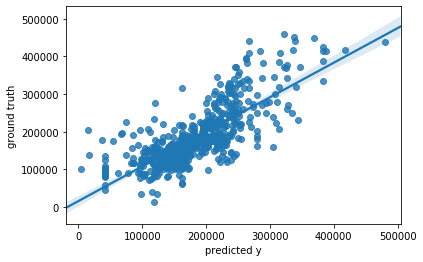

In [498]:
draw_plot(y_predict_rfe,y_test)

In [499]:
metrics_printout(rfe_lm,x_test_transformed_rfe,y_test,y_predict_rfe)

R2 Correlation Score :-2.668984506575078
RMSE is : 49323.672087131374


In [400]:
rfe_ridge = Ridge()
rfe_alphas = np.logspace(0, 20, 1000)


In [401]:
rfe_params = {
    'alpha':rfe_alphas
}

In [402]:
random_search_ridge_rfe = RandomizedSearchCV(estimator=rfe_ridge, param_distributions=rfe_params,cv=5,n_iter=50)

In [403]:
ridge_search_rfe = random_search_ridge_rfe.fit(x_train_transformed_rfe,y_train)

In [404]:
ridge_search_rfe_alpha = ridge_search_rfe.best_params_['alpha']

In [405]:
rfe_ridge_optim = Ridge(alpha=ridge_search_rfe_alpha)

In [406]:
rfe_ridge_optim = rfe_ridge_optim.fit(x_train_transformed_rfe,y_train)

In [407]:
rfe_ridge_optim.score(x_test_transformed_rfe,y_test)

0.8279461176344507

In [408]:
y_predict_rfe_ridge = rfe_ridge_optim.predict(x_test_transformed_rfe)

In [409]:
metrics_printout(rfe_ridge_optim,x_test_transformed_rfe,y_test,y_predict_rfe_ridge)

R2 Correlation Score :0.8279461176344507
RMSE is : 32069.29246732327


## Strategy 2 : Reduce Model Features via RFE

### Reduce Model features using RFE only

In [595]:
rfe_ridge = RFE(ridge_result,n_features_to_select=7)

In [596]:
selector = rfe_ridge.fit(x_train_transformed,y_train)

In [903]:
x_train_transformed.columns[selector.get_support()]

Index(['Total Bsmt SF', 'Gr Liv Area', 'age_since_built', 'house_exter_score',
       'Land Contour_HLS', 'Land Contour_Low', 'Land Contour_Lvl'],
      dtype='object')

In [597]:
new_columns = x_train_transformed.columns[selector.get_support()]

In [598]:
x_train_transformed_rfe = x_train_transformed[new_columns]
x_test_transformed_rfe = x_test_transformed[new_columns]

In [599]:
rfe_lm = LinearRegression()

In [600]:
rfe_lm = rfe_lm.fit(x_train_transformed_rfe,y_train)

In [601]:
rfe_lm.score(x_test_transformed_rfe,y_predict_rfe)

0.826401770903204

In [938]:
y_predict_rfe =  rfe_lm.predict(x_test_transformed_rfe)

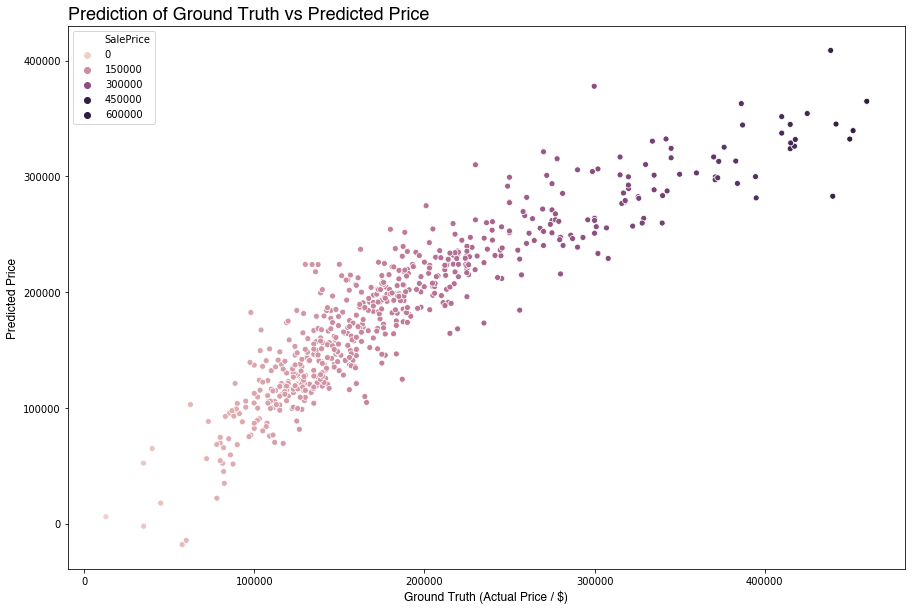

In [946]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x=y_test,y=y_predict_rfe,hue=y_test)
ax.set_title("Prediction of Ground Truth vs Predicted Price", fontname='Helvetica', fontsize=18,loc='left')
ax.set_xlabel('Ground Truth (Actual Price / $)',fontname='Helvetica',fontsize=12)
ax.set_ylabel('Predicted Price',fontname='Helvetica',fontsize=12)
plt.savefig("./img/business_predict.png",dpi=300)

In [604]:
metrics_printout(rfe_lm,x_test_transformed_rfe,y_test,y_predict_rfe)

R2 Correlation Score :0.826401770903204
RMSE is : 32212.89709387416


In [617]:
rfe_lm.intercept_

161623.85238801516

In [605]:
rfe_lm.coef_

array([ 14275.07007118,  30774.32426653, -19829.94681532,  27109.62058867,
        56746.56773649,  40360.62939768,  17598.60324815])

In [615]:
estimator_scaled_coefficients(rfe_lm,new_columns).sort_values(by='coefficient')

,feature,coefficient
2,age_since_built,-1.967492
0,Total Bsmt SF,-0.431713
6,Land Contour_Lvl,-0.282052
3,house_exter_score,0.146238
1,Gr Liv Area,0.311262
5,Land Contour_Low,0.742942
4,Land Contour_HLS,1.480815


In [915]:
new_columns

Index(['Total Bsmt SF', 'Gr Liv Area', 'age_since_built', 'house_exter_score',
       'Land Contour_HLS', 'Land Contour_Low', 'Land Contour_Lvl'],
      dtype='object')

In [607]:
rfe_ridge = Ridge()
rfe_alphas = np.logspace(0, 20, 1000)


In [608]:
rfe_params = {
    'alpha':rfe_alphas
}

In [609]:
random_search_ridge_rfe = RandomizedSearchCV(estimator=rfe_ridge, param_distributions=rfe_params,cv=5,n_iter=50)

In [593]:
ridge_search_rfe = random_search_ridge_rfe.fit(x_train_transformed_rfe,y_train)

In [594]:
ridge_search_rfe_alpha = ridge_search_rfe.best_params_['alpha']

In [573]:
rfe_ridge_optim = Ridge(alpha=ridge_search_rfe_alpha)

In [574]:
rfe_ridge_optim = rfe_ridge_optim.fit(x_train_transformed_rfe,y_train)

In [575]:
rfe_ridge_optim.score(x_test_transformed_rfe,y_test)

0.8275674433549641

In [576]:
y_predict_rfe_ridge = rfe_ridge_optim.predict(x_test_transformed_rfe)

In [577]:
metrics_printout(rfe_ridge_optim,x_test_transformed_rfe,y_test,y_predict_rfe_ridge)

R2 Correlation Score :0.8275674433549641
RMSE is : 32104.56380659157


## Export Ridge Coefficients for Production

In [625]:
prod_model = pd.DataFrame(zip(new_columns,rfe_lm.coef_),columns=['feature','coefficient'])

In [637]:
prod_model = prod_model.append({'feature':'y_intercept','coefficient':rfe_lm.intercept_},ignore_index=True)

In [640]:
prod_model.to_csv('./datasets/cofficients_ridge.csv')